In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import glob
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import re
import pydotplus
import graphviz

In [2]:
x_em=np.load("./tempdata/dis/x_em.npy")
x_mo=np.load("./tempdata/dis/x_mo.npy")
x_la=np.load("./tempdata/dis/x_la.npy")
x_re=np.load("./tempdata/dis/x_re.npy")
x_sc=np.load("./tempdata/dis/x_sc.npy")
x_ga=np.load("./tempdata/dis/x_ga.npy")
x_wm=np.load("./tempdata/dis/x_wm.npy")
x_dis=np.concatenate((x_em,x_mo,x_la,x_re,x_sc,x_ga,x_wm),axis=0)

y_em=np.load("./tempdata/dis/y_em.npy")
y_mo=np.load("./tempdata/dis/y_mo.npy")
y_la=np.load("./tempdata/dis/y_la.npy")
y_re=np.load("./tempdata/dis/y_re.npy")
y_sc=np.load("./tempdata/dis/y_sc.npy")
y_ga=np.load("./tempdata/dis/y_ga.npy")
y_wm=np.load("./tempdata/dis/y_wm.npy")
y=np.concatenate((y_em,y_mo,y_la,y_re,y_sc,y_ga,y_wm),axis=0)


In [3]:
x_train, x_test, y_train, y_test = train_test_split(x_dis, y, test_size=0.2, random_state=5)

In [6]:
rfc_all=RandomForestClassifier(random_state=5).fit(x_train,y_train)

In [123]:
rfc_all.estimators_[0].get_depth()

48

In [15]:
print(classification_report(y_test,rfc_all.predict(x_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2523
         1.0       0.99      1.00      1.00      4311
         2.0       0.99      1.00      1.00      3397
         3.0       0.99      1.00      1.00      2506
         4.0       1.00      0.99      0.99      2120
         5.0       1.00      0.97      0.98      1662
         6.0       0.99      1.00      1.00      3498

    accuracy                           0.99     20017
   macro avg       1.00      0.99      0.99     20017
weighted avg       0.99      0.99      0.99     20017



<Axes: >

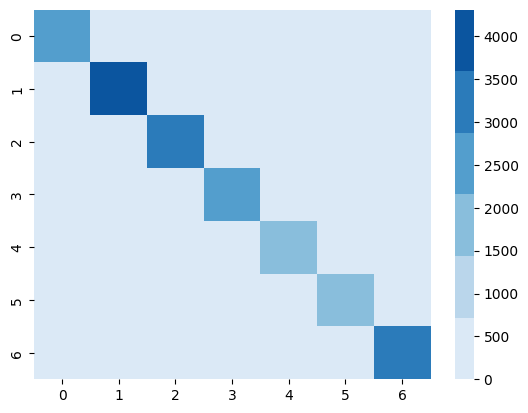

In [8]:
sns.heatmap(confusion_matrix(y_test,rfc_all.predict(x_test)),cmap=sns.color_palette("Blues"))

In [16]:
def build(x1,x2,y1,y2):
    x=np.concatenate((x1,x2),axis=0)
    y=np.concatenate((y1,y2),axis=0)
    x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=5)
    rfc=RandomForestClassifier(random_state=5).fit(x_train,y_train)
    accuracy=rfc.score(x_test,y_test)
    return rfc,accuracy

In [17]:
x_list=[x_em,x_mo,x_la,x_re,x_sc,x_ga,x_wm]
y_list=[y_em,y_mo,y_la,y_re,y_sc,y_ga,y_wm]

In [18]:
rfc_bi=[]
acc_bi=[]
for i in range(7):
    for j in range(7):
        if i==j:
            continue
        rfc_temp,acc_temp=build(x_list[i],x_list[j],y_list[i],y_list[j])
        rfc_bi.append(rfc_temp)
        acc_bi.append(acc_temp)

In [25]:
pattern=re.compile(r'(?<=feature_)\d+\.?\d*')
region_importance_bi=np.zeros((368,))

for rfc in rfc_bi:
    fre=np.zeros((368,1))
    for e in rfc:
        temp=tree.export_text(e,max_depth=2)
        for fea in set(pattern.findall(temp)):
            fre[int(fea)]=fre[int(fea)]+1
    regions=[]
    for i in range(368):
        if fre[i] > np.mean(fre)+np.std(fre):
            regions.append(i)
    for i in regions:
        region_importance_bi[int(i)]=region_importance_bi[int(i)]+1

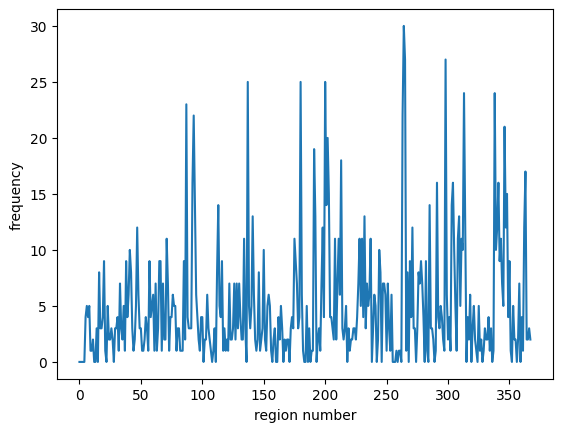

In [124]:
plt.xlabel("region number")
plt.ylabel("frequency")
plt.plot(region_importance_bi)

In [26]:
important_regions_bi=[]
for i in range(368):
    if region_importance_bi[i] > np.mean(region_importance_bi)+np.std(region_importance_bi):
        important_regions_bi.append(i+1)

In [27]:
np.savetxt("./tempdata/important_regions_bi",important_regions_bi)

In [28]:
%%bash
python3 markRegions.py ./tempdata/important_regions_bi important_regions_bi.nii.gz

In [75]:
mask_region_bi=np.zeros((368,))
for i in important_regions_bi:
    mask_region_bi[i-1]=mask_region_bi[i-1]+1

In [79]:
x_list_sub=[]
for i in x_list:
    x_list_sub.append(np.multiply(i,mask_region_bi))

In [81]:
rfc_sin=[]
acc_sin=[]
for i in range(7):
    x1_temp=x_list_sub[i]
    y1_temp=np.zeros(y_list[i].shape)
    x2_temp=np.zeros((0,368))
    y2_temp=np.zeros((0,))
    for j in range(7):
        if i==j:
            continue
        x2_temp=np.concatenate((x2_temp,x_list_sub[j]),axis=0)
        y2_temp=np.concatenate((y2_temp,y_list[j]),axis=0)
    y2_temp=np.ones((y2_temp.shape))
    rfc_temp,acc_temp=build(x1_temp,x2_temp,y1_temp,y2_temp)
    rfc_sin.append(rfc_temp)
    acc_sin.append(acc_temp)
    

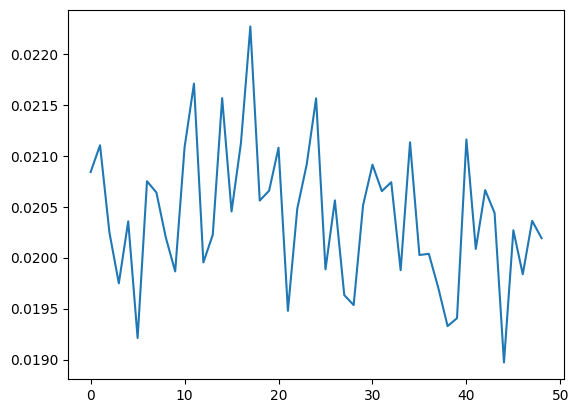

In [105]:
plt.plot(rfc_sin[0].feature_importances_[np.array(important_regions_bi)-1])

In [109]:
important_regions_sin=[]
for i in range(7):
    rfc_temp=rfc_sin[i]
    thresold=np.mean(rfc_temp.feature_importances_[np.array(important_regions_bi)-1])+np.std(rfc_temp.feature_importances_[np.array(important_regions_bi)-1])
    regions=[]
    for j in range(368):
        if rfc_temp.feature_importances_[j] > thresold:
            regions.append(j+1)
    important_regions_sin.append(regions)
    np.savetxt("./tempdata/sin/important_region_sin_"+str(i),regions)

In [112]:
important_regions_sin_all=[]
for i in range(7):
    for j in important_regions_sin[i]:
        if j not in important_regions_sin_all:
            important_regions_sin_all.append(j)
np.savetxt("./tempdata/sin/important_region_sin_all",important_regions_sin_all)

In [113]:
%%bash
python3 markRegions.py ./tempdata/sin/important_region_sin_all important_regions_sin.nii.gz

In [114]:
%%bash
python3 markRegions.py ./tempdata/sin/important_region_sin_0 em_important_regions_sin.nii.gz
python3 markRegions.py ./tempdata/sin/important_region_sin_1 mo_important_regions_sin.nii.gz
python3 markRegions.py ./tempdata/sin/important_region_sin_2 la_important_regions_sin.nii.gz
python3 markRegions.py ./tempdata/sin/important_region_sin_3 re_important_regions_sin.nii.gz
python3 markRegions.py ./tempdata/sin/important_region_sin_4 sc_important_regions_sin.nii.gz
python3 markRegions.py ./tempdata/sin/important_region_sin_5 ga_important_regions_sin.nii.gz
python3 markRegions.py ./tempdata/sin/important_region_sin_6 wm_important_regions_sin.nii.gz

In [115]:
feature_importances_sin=np.zeros((7,368,))
for i in range(7):
    feature_importances_sin[i]=rfc_sin[i].feature_importances_

<Axes: >

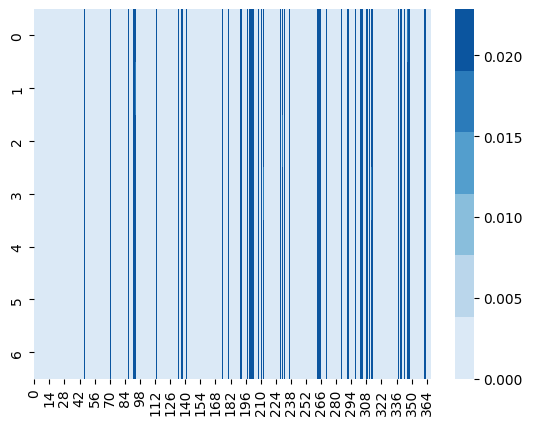

In [116]:
sns.heatmap(feature_importances_sin,cmap=sns.color_palette("Blues"))

In [121]:
feature_importances_sub=np.zeros((7,21,))
j=0
for i in important_regions_sin_all:
    feature_importances_sub[:,j]=feature_importances_sin[:,i-1]
    j=j+1

<Axes: >

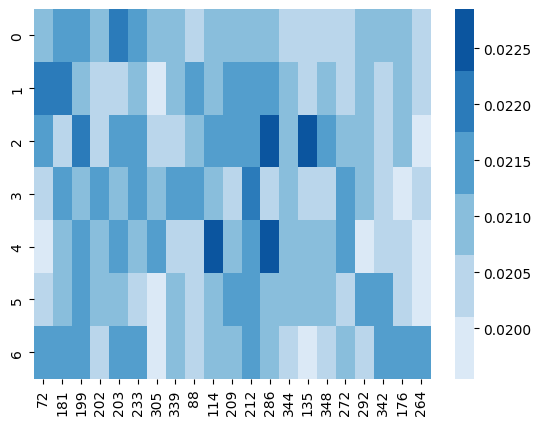

In [122]:
sns.heatmap(feature_importances_sub,cmap=sns.color_palette("Blues"),xticklabels=important_regions_sin_all)

In [29]:
mask_importance=np.zeros((368,))
for i in important_regions_sin_all:
    mask_importance[i-1]=mask_importance[i-1]+1

In [30]:
x_sim=np.zeros(x_dis.shape)
for i in range(x_dis.shape[0]):
    x_sim[i]=np.multiply(x_dis[i],mask_importance)

In [31]:
x_sim_train, x_sim_test, y_sim_train, y_sim_test = train_test_split(x_sim, y, test_size=0.2, random_state=5)
rfc_sim=RandomForestClassifier(random_state=5).fit(x_sim_train,y_sim_train)
rfc_sim.score(x_sim_test,y_sim_test)

0.996552930009492

<Axes: >

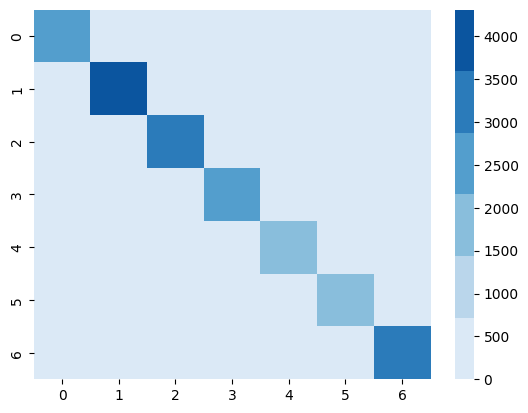

In [128]:
sns.heatmap(confusion_matrix(y_sim_test,rfc_sim.predict(x_sim_test)),cmap=sns.color_palette("Blues"))

In [32]:
dec_tree=tree.DecisionTreeClassifier(random_state=5).fit(x_sim_train,y_sim_train)
dec_tree.score(x_sim_test,y_sim_test)

0.8774042064245391

In [33]:
dec_tree_full=tree.DecisionTreeClassifier(random_state=5).fit(x_train,y_train)
dec_tree_full.score(x_test,y_test)

0.8627166908128091

In [34]:
SVMclf=svm.LinearSVC(random_state=5).fit(x_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [39]:
print(classification_report(y_test,SVMclf.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.14      0.09      0.11      2523
         1.0       0.24      0.56      0.33      4311
         2.0       0.22      0.04      0.07      3397
         3.0       0.14      0.16      0.15      2506
         4.0       0.14      0.16      0.15      2120
         5.0       0.11      0.02      0.03      1662
         6.0       0.20      0.11      0.14      3498

    accuracy                           0.20     20017
   macro avg       0.17      0.16      0.14     20017
weighted avg       0.18      0.20      0.16     20017



<Axes: >

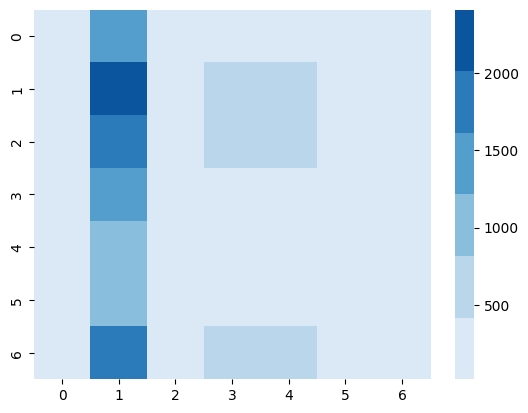

In [40]:
sns.heatmap(confusion_matrix(y_test,SVMclf.predict(x_test)),cmap=sns.color_palette("Blues"))

In [4]:
x_dis_norm=(x_dis-x_dis.mean())/x_dis.std()
x_norm_train, x_norm_test, y_norm_train, y_norm_test = train_test_split(x_dis_norm, y, test_size=0.2, random_state=5)


In [50]:
x_norm_sub,_,y_norm_sub,_=train_test_split(x_dis_norm, y, test_size=0.99, random_state=5)

In [51]:
x_norm_sub_train, x_norm_sub_test, y_norm_sub_train, y_norm_sub_test = train_test_split(x_norm_sub, y_norm_sub, test_size=0.2, random_state=5)


In [52]:
y_norm_sub_train.shape

(800,)

In [53]:
SVMclf_norm_sub=svm.LinearSVC(random_state=5,dual=False).fit(x_norm_sub_train,y_norm_sub_train)

In [54]:
SVMclf_norm_sub.score(x_norm_sub_test,y_norm_sub_test)

0.135

<Axes: >

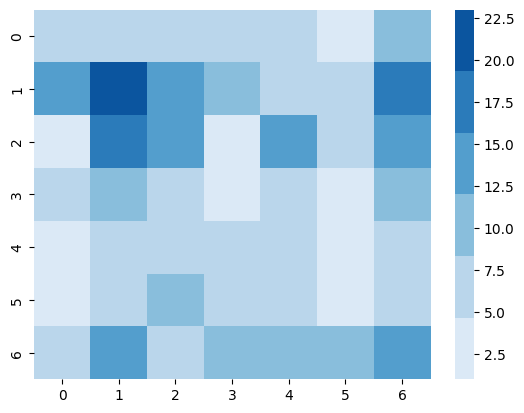

In [48]:
sns.heatmap(confusion_matrix(y_norm_sub_test,SVMclf_norm_sub.predict(x_norm_sub_test)),cmap=sns.color_palette("Blues"))

In [35]:
knc=KNeighborsClassifier().fit(x_train,y_train)

In [41]:
print(classification_report(y_test,knc.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2523
         1.0       0.91      1.00      0.95      4311
         2.0       0.94      0.99      0.96      3397
         3.0       0.92      0.93      0.93      2506
         4.0       0.95      0.81      0.88      2120
         5.0       0.99      0.54      0.70      1662
         6.0       0.91      1.00      0.95      3498

    accuracy                           0.93     20017
   macro avg       0.93      0.89      0.90     20017
weighted avg       0.93      0.93      0.92     20017



<Axes: >

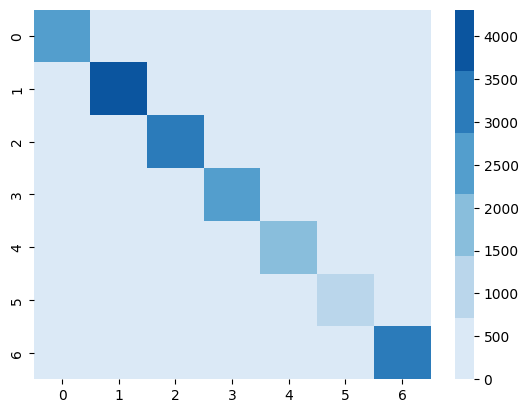

In [42]:
sns.heatmap(confusion_matrix(y_test,knc.predict(x_test)),cmap=sns.color_palette("Blues"))

In [54]:
MLP=MLPClassifier()
param={
    "activation" : Categorical(["logistic","tanh","relu"]),
    "hidden_layer_sizes" : tuple(range(10,201,20)),
    "solver" : Categorical(["sgd", "adam"]),
    "alpha" : Real(1e-4,1e-2,'log-uniform'),
    }
by_search=BayesSearchCV(MLP,param,cv=10)
by_search.fit(x_train,y_train)

BayesSearchCV(cv=10, estimator=MLPClassifier(random_state=5),
              search_spaces={'activation': Categorical(categories=('logistic', 'tanh', 'relu'), prior=None),
                             'alpha': Real(low=0.0001, high=0.01, prior='log-uniform', transform='normalize'),
                             'hidden_layer_sizes': (10, 30, 50, 70, 90, 110,
                                                    130, 150, 170, 190),
                             'solver': Categorical(categories=('sgd', 'adam'), prior=None)})

In [58]:
MLPclf=by_search.best_estimator_
MLPclf.fit(x_train,y_train)

MLPClassifier(alpha=0.000100935098582875, hidden_layer_sizes=170,
              random_state=5)

In [59]:
print(classification_report(y_test,MLPclf.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2523
         1.0       0.22      1.00      0.35      4311
         2.0       0.33      0.00      0.00      3397
         3.0       0.00      0.00      0.00      2506
         4.0       1.00      0.00      0.00      2120
         5.0       0.00      0.00      0.00      1662
         6.0       0.25      0.00      0.00      3498

    accuracy                           0.22     20017
   macro avg       0.26      0.14      0.05     20017
weighted avg       0.25      0.22      0.08     20017



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

<Axes: >

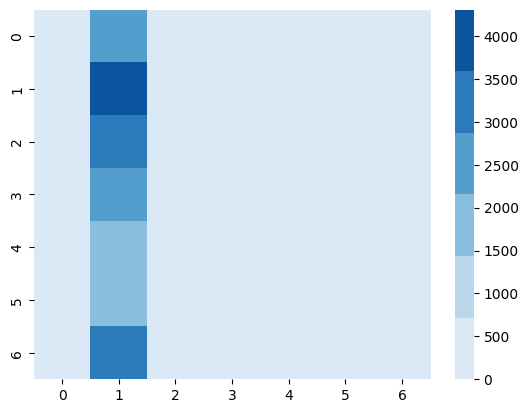

In [60]:
sns.heatmap(confusion_matrix(y_test,MLPclf.predict(x_test)),cmap=sns.color_palette("Blues"))

In [20]:
MLPclf_norm=MLPClassifier(random_state=5,activation="logistic",hidden_layer_sizes=150,max_iter=300).fit(x_norm_train,y_norm_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
MLPclf_norm.score(x_norm_test,y_norm_test)

0.8562222111205475

<Axes: >

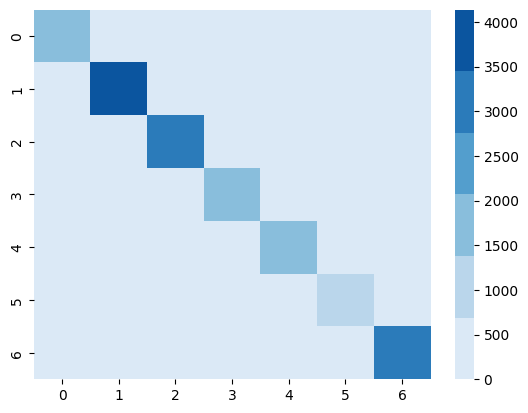

In [22]:
sns.heatmap(confusion_matrix(y_norm_test,MLPclf_norm.predict(x_norm_test)),cmap=sns.color_palette("Blues"))

In [9]:
dot_data=tree.export_graphviz(dec_tree,max_depth=10)
tree_graph=graphviz.Source(dot_data)
tree_graph.render("dectree_em_mo")

array([[-1.322359  ,  4.51278732, -3.5147771 , ..., -3.04095655,
        -4.08048616, -5.38036752],
       [-0.2398032 ,  2.79250392, -0.98256285, ..., -1.82199723,
        -1.76943307, -2.41496971],
       [ 0.11465562,  2.46006033, -0.67170856, ..., -0.47360522,
        -1.56760674, -2.18016411],
       ...,
       [-1.2154507 ,  0.82996634, -1.29052983, ..., -0.75476611,
        -0.9968129 , -1.09160335],
       [-0.31160618, -0.14455335, -0.66280314, ..., -0.46156075,
        -0.62394445, -1.24184917],
       [-0.16135004,  7.22112614, -2.230689  , ..., -5.21399385,
        -6.7600179 , -4.88895315]])